# Calculating derived outputs

In the [previous example](/examples/1-basic-model.html) you saw how to create and run a compartmental model.

This example shows you how you can request more detailed outputs from the model, rather than just the compartment sizes. Summer supports the calculation of "derived outputs": these are addition outputs that are calculated from either:

- the model compartment sizes for each timestep; or
- the model flow rates at each timestep

There are several different types of derived outputs that will be presented in this example:

- **[Flow output](/model.html#summer.model.CompartmentalModel.request_output_for_flow)**: A sum of one or more flow rates at each timestep
- **[Compartment output](/model.html#summer.model.CompartmentalModel.request_output_for_compartments)**: A sum of one or more compartments at each timestep
- **[Aggregate output](/model.html#summer.model.CompartmentalModel.request_aggregate_output)**: An aggregate of other derived outputs
- **[Cumulative output](/model.html#summer.model.CompartmentalModel.request_cumulative_output)**: A cumulative sum of another derived output
- **[Function output](/model.html#summer.model.CompartmentalModel.request_function_output)**: A pure function of other derived outputs

For starters, let's define some utility functions to create a SIR model that is similar to the one from the last example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a new SIR model"""
    model = CompartmentalModel(
        times=[1990, 2010],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": 990, "I": 10})
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")
    model.add_sojourn_flow(name="recovery", sojourn_time=3, source="I", dest="R")
    model.add_death_flow(name="infection_death", death_rate=0.5, source="I")
    return model

def plot_output(model, name, title):
    """Plot a derived output for a model"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    ax.plot(model.times, model.derived_outputs[name])
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(name)
    plt.show()

# Force NumPy to format printed arrays nicely. 
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

Let's quickly visualize what the compartments are doing over time:

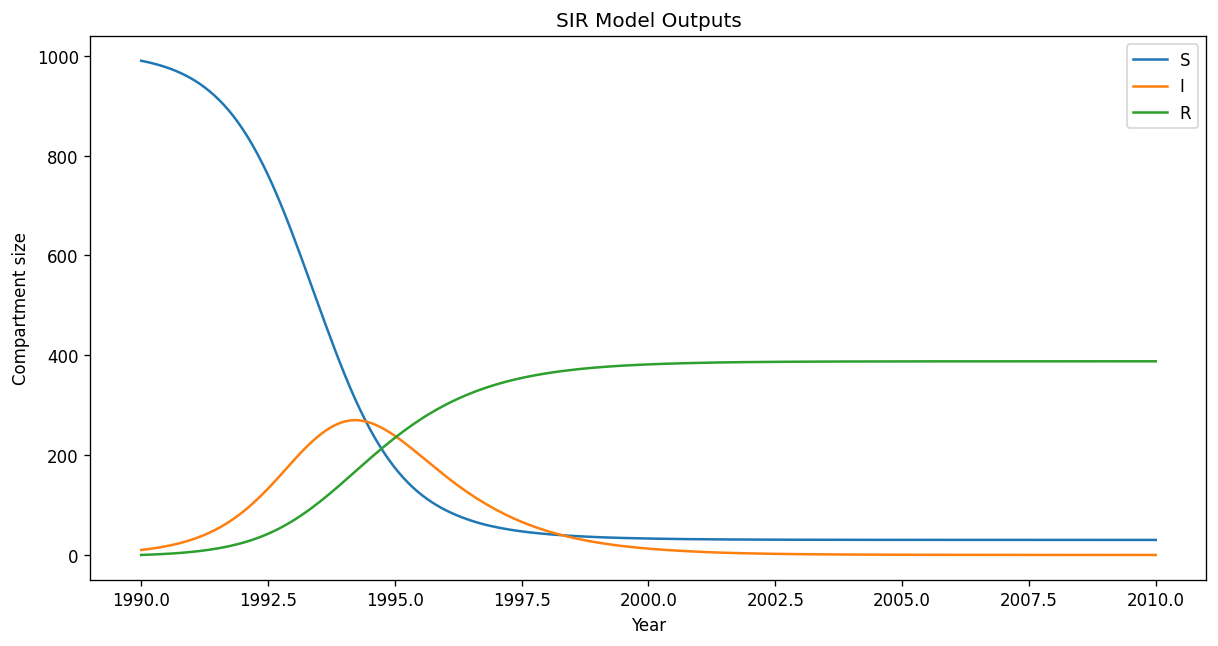

In [2]:
model = build_model()
model.run()
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)

# Add each compartment to the plot.
for i in range(model.outputs.shape[1]):
    ax.plot(model.times, model.outputs.T[i])

ax.set_title("SIR Model Outputs")
ax.set_xlabel("Year")
ax.set_ylabel("Compartment size")
ax.legend(["S", "I", "R"])
plt.show()

## Requesting derived outputs

We can ask a model to calculate extra outputs that are derived from the compartment sizes and flow rates. For example, we might want to ask the model to track the number of people who died from infection per timestep.

In [3]:
# Create a model (see above)
model = build_model()

# Request that the model calculate a derived output when it is run.
model.request_output_for_flow(name="deaths", flow_name="infection_death")

Now when we run the model, it will create an NumPy array of infection deaths that we can access via `model.derived_outputs`.

In [4]:
# Run the model
model.run()

# View the derived outputs dictionary that we calculated when `run()` was called.
print("Derived outputs:\n", model.derived_outputs)

Derived outputs:
 {'deaths': array([0.00, 0.53, 0.59, 0.66, 0.73, 0.82, 0.91, 1.01, 1.13, 1.25, 1.39,
       1.55, 1.72, 1.91, 2.11, 2.33, 2.58, 2.84, 3.13, 3.45, 3.78, 4.15,
       4.54, 4.95, 5.39, 5.85, 6.34, 6.84, 7.36, 7.89, 8.43, 8.98, 9.52,
       10.04, 10.55, 11.03, 11.48, 11.90, 12.27, 12.61, 12.89, 13.12,
       13.30, 13.42, 13.49, 13.49, 13.44, 13.33, 13.18, 12.99, 12.75,
       12.48, 12.18, 11.85, 11.50, 11.13, 10.75, 10.36, 9.96, 9.56, 9.16,
       8.76, 8.36, 7.98, 7.60, 7.23, 6.87, 6.52, 6.19, 5.86, 5.55, 5.26,
       4.97, 4.69, 4.43, 4.18, 3.94, 3.71, 3.50, 3.29, 3.10, 2.91, 2.74,
       2.58, 2.42, 2.28, 2.14, 2.01, 1.89, 1.77, 1.66, 1.56, 1.46, 1.37,
       1.29, 1.21, 1.13, 1.06, 0.99, 0.93, 0.87, 0.82, 0.77, 0.72, 0.67,
       0.63, 0.59, 0.56, 0.52, 0.49, 0.46, 0.43, 0.40, 0.38, 0.35, 0.33,
       0.31, 0.29, 0.27, 0.25, 0.23, 0.22, 0.20, 0.19, 0.18, 0.17, 0.16,
       0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.10, 0.09, 0.09, 0.08, 0.07,
       0.07, 0.07, 0.06, 0.

## Flow outputs

A **[flow output](/model.html#summer.model.CompartmentalModel.request_output_for_flow)** tracks a set of requested flow rates for each timestep. These requests can also select flows between particular strata in a stratified model (see later examples).

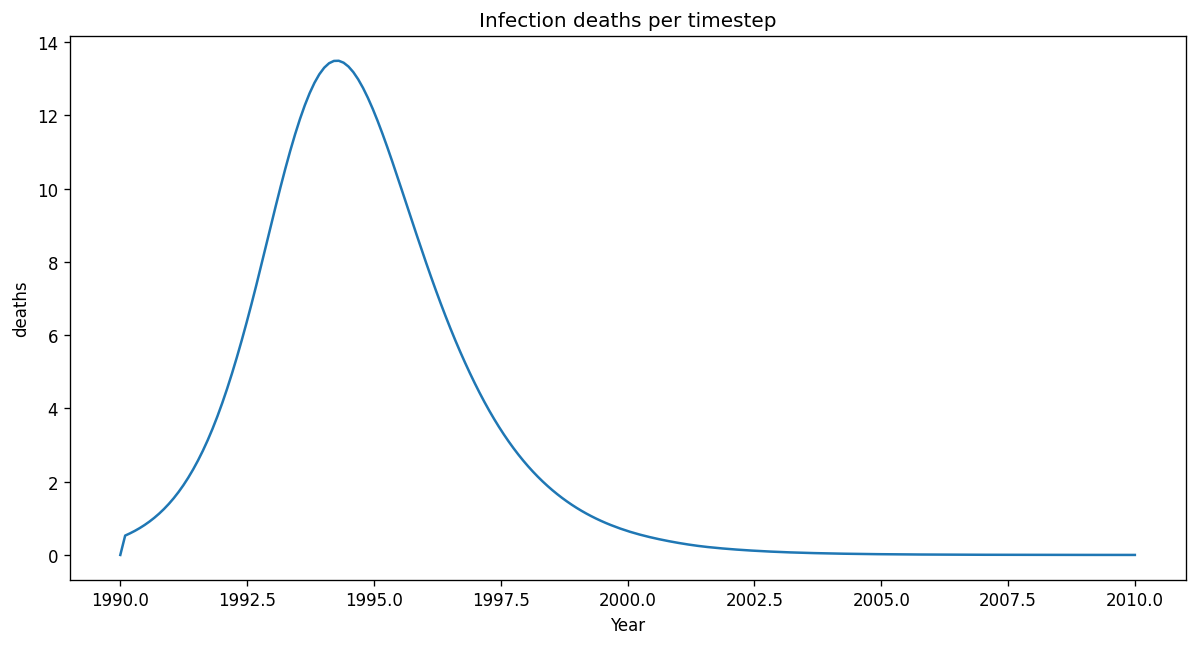

In [5]:
model = build_model()

# Request that the 'infection_death' flow is tracked as a derived output named 'deaths'.
model.request_output_for_flow(name="deaths", flow_name="infection_death")

model.run()
plot_output(model, 'deaths', "Infection deaths per timestep")

## Cumulative outputs

You can use a  **[cumulative output](/model.html#summer.model.CompartmentalModel.request_cumulative_output)** to request that the model tracks the cumulative sum of other derived outputs over time. For example, let's track total infection deaths and the total people recovered:

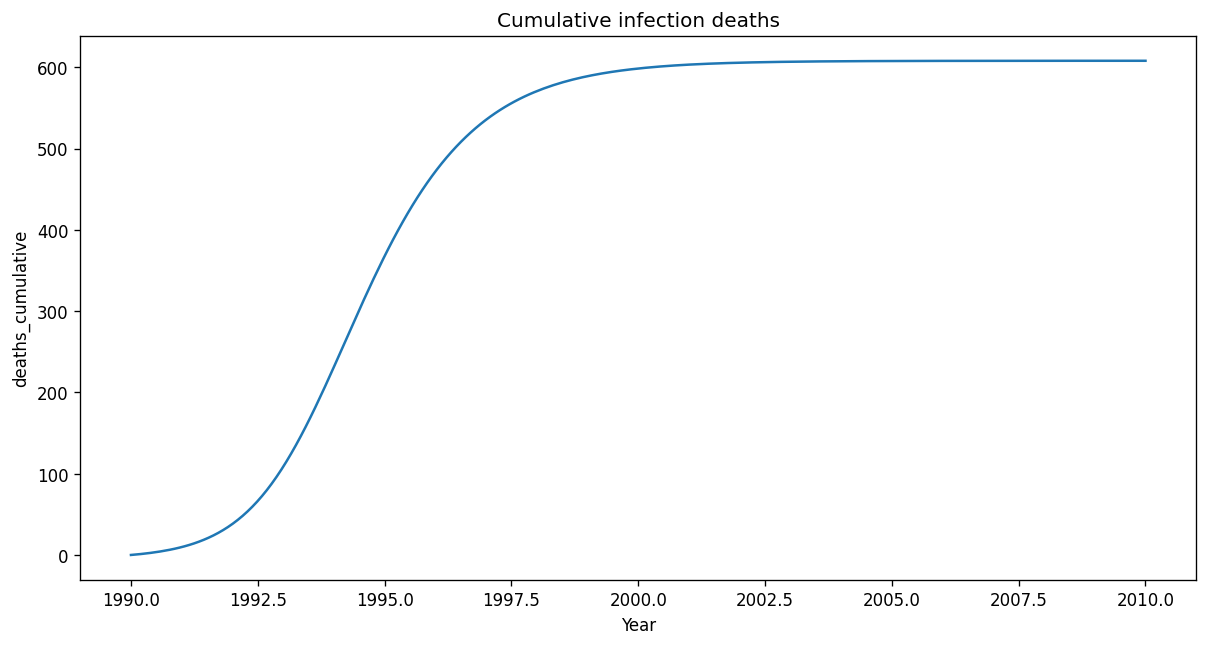

In [6]:
model = build_model()
model.request_output_for_flow(name="deaths", flow_name="infection_death")

# Request that the 'deaths' derived output is accumulated into 'deaths_cumulative'.
model.request_cumulative_output(name="deaths_cumulative", source="deaths")

model.run()
plot_output(model, 'deaths_cumulative', "Cumulative infection deaths")

## Compartment outputs

A **[compartment output](/model.html#summer.model.CompartmentalModel.request_output_for_compartments)** tracks the sum of one or more compartments at each timestep. These requests can also select compartments for particular strata in a stratified model (see later examples).

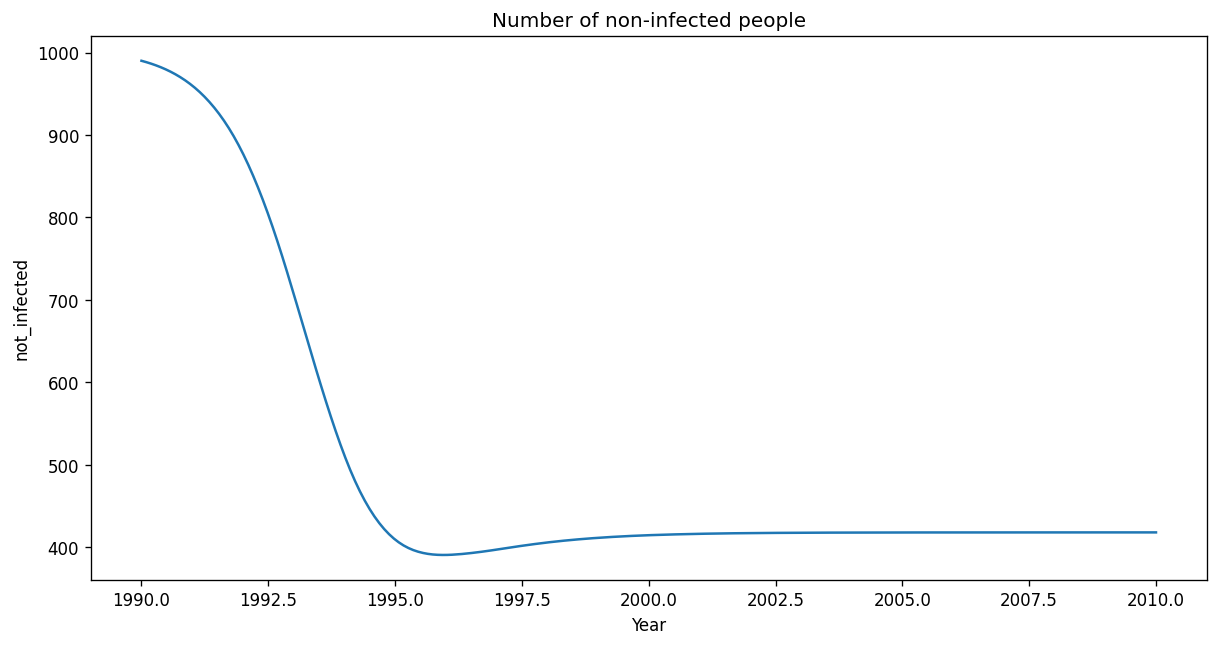

In [7]:
model = build_model()

# Request that the S and R compartment sizes are combined into 'not_infected'.
model.request_output_for_compartments(name='not_infected', compartments=['S', 'R'])

model.run()
plot_output(model, 'not_infected', "Number of non-infected people")

## Aggregate outputs

You can use an **[aggregate output](/model.html#summer.model.CompartmentalModel.request_aggregate_output)** to request an aggregate of other derived outputs.

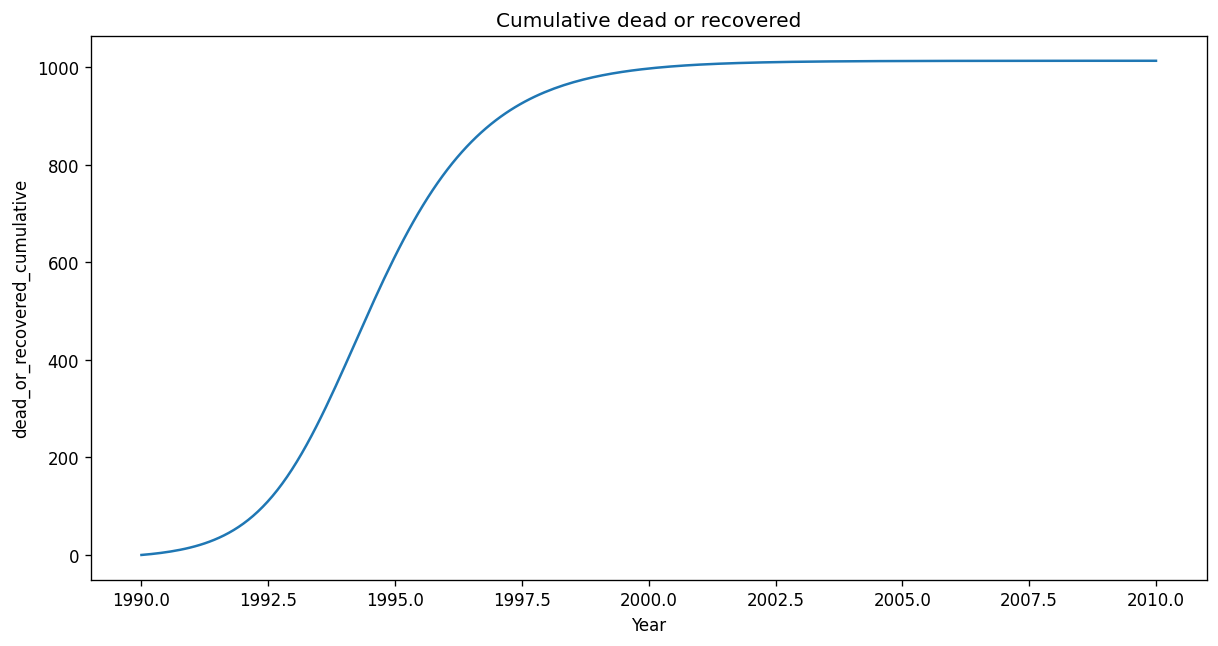

In [8]:
model = build_model()

# Track some flows.
model.request_output_for_flow(name="deaths", flow_name="infection_death")
model.request_output_for_flow(name="recovered", flow_name="recovery")

# Accumulate the flows.
model.request_cumulative_output(name="deaths_cumulative", source="deaths")
model.request_cumulative_output(name="recovered_cumulative", source="recovered")

# Aggregate 'deaths_cumulative' and 'recovered_cumulative' into a single output
model.request_aggregate_output(
    name="dead_or_recovered_cumulative",
    sources=['deaths_cumulative', 'recovered_cumulative']
)

model.run()
plot_output(model, 'dead_or_recovered_cumulative', "Cumulative dead or recovered")

## Function outputs

You can use **[function outputs](/model.html#summer.model.CompartmentalModel.request_function_output)** to calculate outputs with a user-defined function. This function takes the requested sources (NumPy arrays) as inputs and should return a NumPy array of the same size.

For example, here we request a calculation that gets us the prevalence of the disease.

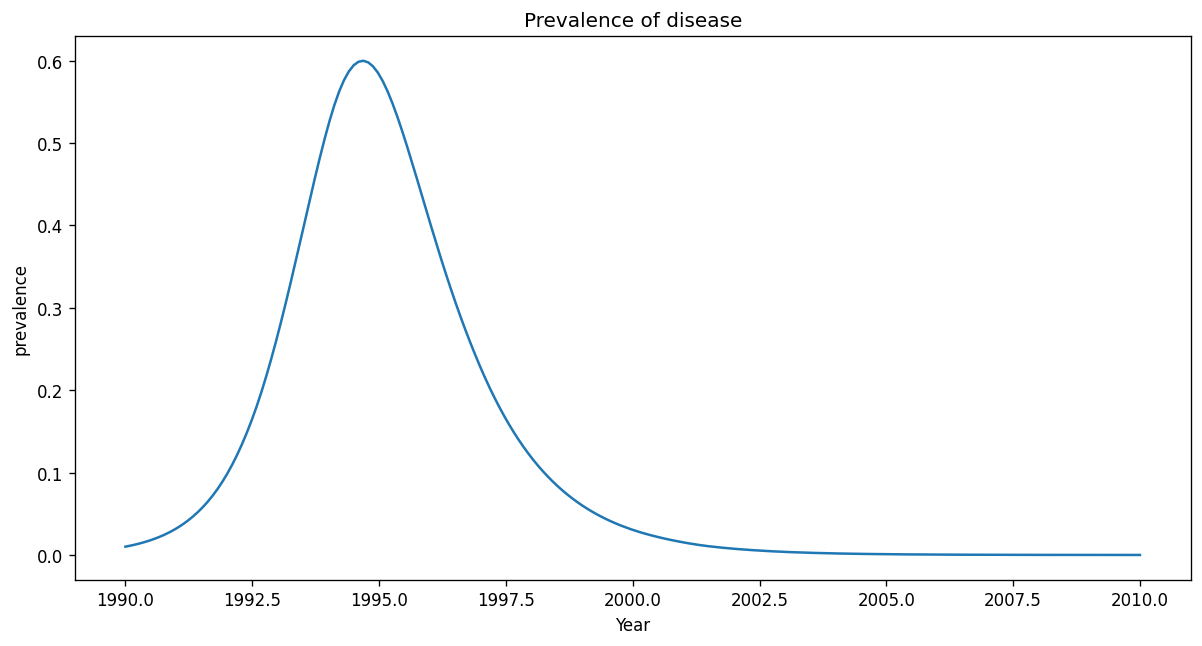

In [9]:
model = build_model()

# Track the number of infectious people as a derived output.
# Here we use `save_results=False` because we don't need to use this later.
model.request_output_for_compartments(name="count_infectious", compartments=["I"], save_results=False)

# Track the total population as a derived output.
model.request_output_for_compartments(name="total_population", compartments=["S", "R"], save_results=False)

# Define a function that we will use to calculate prevalence.
# The arguments (infectious, total) will be NumPy arrays.
def get_prevalence(infectious, total):
    return infectious / total

# Request a function output, using `get_prevalence`.
# The sources will map to the function arguments.
model.request_function_output(
    name="prevalence",
    sources=["count_infectious", "total_population"],
    func=get_prevalence,
)

model.run()
plot_output(model, 'prevalence', "Prevalence of disease")

## Summary

That's it for now, now you know how to:

- Request derived outputs
- Chain and combine derived outputs
- Access and visualize the derived outputs

A detailed API reference of the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)